In [51]:
import os
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# Our library
from rna_modification_detection.fast5 import Fast5
# pip install py3helpers (my library)
from py3helpers.utils import list_dir


Using TensorFlow backend.


In [82]:
# set home and find test files
HOME = "/Users/andrewbailey/PycharmProjects/rna_modification_detection"
native_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/nop58_fast5")
native_fast5_files = list_dir(native_18S_dir, ext="fast5")
ivt_18S_dir = os.path.join(HOME, "tests/test_files/test_18S_full_length/ivt_fast5")
ivt_fast5_files = list_dir(native_18S_dir, ext="fast5")


In [83]:
# read in test file 
fh = Fast5(native_fast5_files[0])
signal = fh.get_read(raw=True, scale=True)
events = pd.DataFrame(fh.get_signalalign_events(mea=True))
# signal = fh.get_read(raw=True, scale=False)
events.head()


,raw_start,raw_length,reference_index,posterior_probability,kmer
0,4032,14,1794,0.999959,b'TTACT'
1,4046,14,1793,0.998710,b'TACTA'
2,4060,8,1792,0.998710,b'ACTAG'
3,4068,63,1791,0.789126,b'CTAGG'
4,4131,43,1790,0.661411,b'TAGGA'


<IPython.core.display.Javascript object>


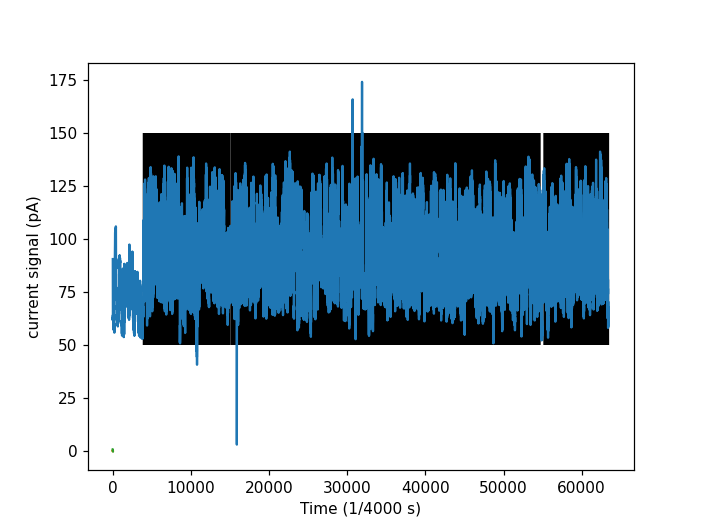

In [84]:
%matplotlib notebook
# plot signal and events data 
plt.plot(signal)
plt.vlines(events["raw_start"], ymin = 50, ymax=150)
plt.ylabel('current signal (pA)')
plt.xlabel('Time (1/4000 s)')

plt.show()



In [85]:
def get_raw_signal(fast5_file, ref_position, window=200):
    """Get a window of raw signal around a given reference position
    :param fast5_file: path to fast5 file
    :param ref_position: integer reference position
    :param window: number of current signals to collect (should be even)
    """
    delta = window // 2
#     read in file
    fh = Fast5(fast5_file)
    #     get events and signal
    signal = fh.get_read(raw=True, scale=True)
    signal = StandardScaler().fit_transform(np.array(signal).reshape(-1, 1))
#     signal = MinMaxScaler(feature_range=(0, 1)).fit_transform(np.array(signal).reshape(-1, 1))
    events = pd.DataFrame(fh.get_signalalign_events(mea=True))
    #     get signal index
    mod_signal_index = events[events["reference_index"] == ref_position].raw_start.iloc[0]
    #     define window
    window_start = mod_signal_index - delta
    window_end = mod_signal_index + delta 
    return signal[window_start:window_end]

In [87]:
# Train test split
train_size = int(len(native_fast5_files) * 0.67)
test_size = len(native_fast5_files) - train_size
mod_train, mod_test = native_fast5_files[0:train_size], native_fast5_files[train_size:len(native_fast5_files)]
ivt_train, ivt_test = native_fast5_files[0:train_size], ivt_fast5_files[train_size:len(native_fast5_files)]

print(len(mod_train), len(mod_test))
print(len(ivt_train), len(ivt_test))

6 4
6 4


In [88]:
# pick mod to predict
# This one has >95% modification status and I have predicted it well with other tools 
# 2’-O-Methyladenosine
ref_position = 796
# number of current signals to collect (should be even)
window = 200
def create_dataset(mod_files, ivt_files, ref_position, window=200):
    dataX, dataY = [], []
    for file in mod_files:
        dataX.append(get_raw_signal(file, ref_position, window=window))
        dataY.append(1)
    for file in ivt_files:
        dataX.append(get_raw_signal(file, ref_position, window=window))
        dataY.append(0)

    return np.array(dataX), np.array(dataY)

trainX, trainY = create_dataset(mod_train, ivt_train, ref_position, window=200)
testX, testY = create_dataset(mod_test, ivt_test, ref_position, window=200)

In [89]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(12, 200, 1) (12,)
(8, 200, 1) (8,)


In [90]:
model = Sequential()
model.add(LSTM(4, input_shape=(None, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [97]:
# fit
model.fit(trainX, trainY, epochs=100, batch_size=2, verbose=2)

Epoch 1/100
 - 2s - loss: 0.3157
Epoch 2/100
 - 2s - loss: 0.3072
Epoch 3/100
 - 1s - loss: 0.3036
Epoch 4/100
 - 1s - loss: 0.2963
Epoch 5/100
 - 2s - loss: 0.2924
Epoch 6/100
 - 1s - loss: 0.2889
Epoch 7/100
 - 1s - loss: 0.2817
Epoch 8/100
 - 2s - loss: 0.2775
Epoch 9/100
 - 1s - loss: 0.2744
Epoch 10/100
 - 2s - loss: 0.2725
Epoch 11/100
 - 2s - loss: 0.2672
Epoch 12/100
 - 2s - loss: 0.2633
Epoch 13/100
 - 2s - loss: 0.2615
Epoch 14/100
 - 2s - loss: 0.2584
Epoch 15/100
 - 2s - loss: 0.2567
Epoch 16/100
 - 2s - loss: 0.2556
Epoch 17/100
 - 2s - loss: 0.2544
Epoch 18/100
 - 2s - loss: 0.2534
Epoch 19/100
 - 2s - loss: 0.2526
Epoch 20/100
 - 2s - loss: 0.2518
Epoch 21/100
 - 2s - loss: 0.2510
Epoch 22/100
 - 2s - loss: 0.2514
Epoch 23/100
 - 2s - loss: 0.2507
Epoch 24/100
 - 2s - loss: 0.2506
Epoch 25/100
 - 2s - loss: 0.2507
Epoch 26/100
 - 2s - loss: 0.2507
Epoch 27/100
 - 2s - loss: 0.2509
Epoch 28/100
 - 1s - loss: 0.2508
Epoch 29/100
 - 2s - loss: 0.2503
Epoch 30/100
 - 2s - lo

In [100]:
# predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.50 RMSE
Test Score: 0.51 RMSE


<IPython.core.display.Javascript object>


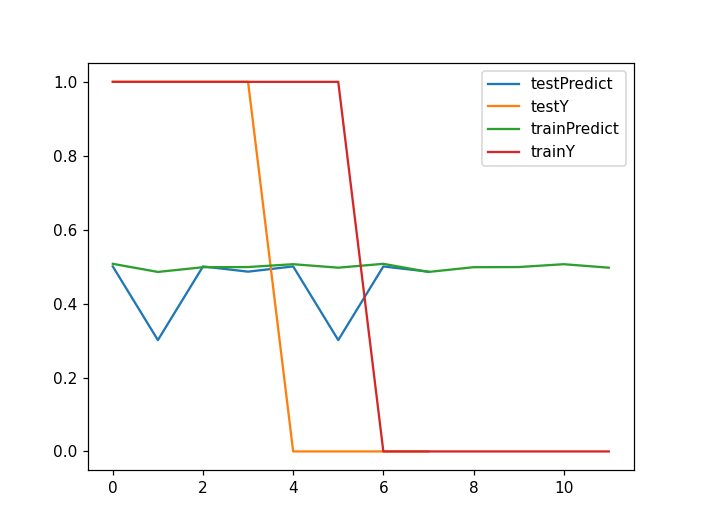

In [103]:
%matplotlib notebook
plt.plot(testPredict, label="testPredict")
plt.plot(testY, label="testY")
plt.plot(trainPredict, label="trainPredict")
plt.plot(trainY, label="trainY")
plt.legend()
plt.show()